# Tiling Window-based Prediction using `torch-em`

This notebook shows how to use tiling window-based prediction from a custom trained model.

We use electron microscopy images for neuron segmentation (from https://cremi.org/).

## Running this notebook

If you have an environment with µsam on your computer you can run this notebook in there. You can follow the [installation instructions](https://github.com/constantinpape/torch-em?tab=readme-ov-file#installation) to install it on your computer.

You can also run this notebook in the cloud on [Kaggle Notebooks](https://www.kaggle.com/code/). This service offers free usage of a GPU to speed up running the code. The next cells will take care of the installation for you if you are using it.

In [1]:
# Check if we are running this notebook on kaggle, google colab or local compute resources.
import os
current_spot = os.getcwd()

if current_spot.startswith("/kaggle/working"):
    print("Kaggle says hi!")
    root_dir = "/kaggle/working"

elif current_spot.startswith("/content"):
    print("Google Colab says hi!")
    print(" NOTE: The scripts have not been tested on Google Colab, you might need to adapt the installations a bit.")
    root_dir = "/content"

    # You might need to install condacolab on Google Colab to be able to install packages using conda / mamba
    # !pip install -q condacolab
    # import condacolab
    # condacolab.install()

else:
    msg = "You are using a behind-the-scenes resource. Follow our installation instructions here:"
    msg += " https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation"
    print(msg)
    root_dir = ""  # overwrite to set the root directory, where the data, checkpoints, and all relevant stuff will be stored

Kaggle says hi!


### Installation
The next cells will install the `torch-em` library (and other relevant packages) on Kaggle Notebooks. **Please skip these cells and go to `Importing the libraries` if you are running the notebook on your own computer.**

In [2]:
!git clone --quiet https://github.com/constantinpape/torch-em.git
tmp_dir = os.path.join(root_dir, "torch-em")
!pip install --quiet $tmp_dir

In [3]:
!git clone --quiet https://github.com/constantinpape/elf.git
tmp_dir = os.path.join(root_dir, "elf")
!pip install --quiet $tmp_dir

In [4]:
!mamba install -q -y -c conda-forge nifty affogato natsort > /dev/null 2>&1

### Importing the libraries

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

import torch

import torch_em
from torch_em.model import UNet3d
from torch_em.data.datasets import get_cremi_loader
from torch_em.util.prediction import predict_with_halo
from torch_em.data.datasets.electron_microscopy.cremi import get_cremi_paths

device = "cuda" if torch.cuda.is_available() else "cpu"  # overwrite this to provide the device of your choice for training the model.

/opt/conda/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Training a custom model

We call the PyTorch dataloaders for the CREMI dataset already available in `torch-em`. If you would like to create your own dataloaders, we recommend taking a look at the [tutorial notebook](https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb).

In [6]:
train_rois = {"A": np.s_[0:75, :, :], "B": np.s_[0:75, :, :], "C": np.s_[0:75, :, :]}
val_rois = {"A": np.s_[75:100, :, :], "B": np.s_[75:100, :, :], "C": np.s_[75:100, :, :]}

data_path = os.path.join(root_dir, "data", "cremi")

train_loader = get_cremi_loader(
    path=data_path,
    patch_shape=(16, 512, 512),
    batch_size=1,
    boundaries=True,
    rois=train_rois,
    download=True,
)

val_loader = get_cremi_loader(
    path=data_path,
    patch_shape=(16, 512, 512),
    batch_size=1,
    boundaries=True,
    rois=val_rois,
    download=True,
)

/opt/conda/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cremi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Download https://cremi.org/static/data/sample_A_20160501.hdf to /kaggle/working/data/cremi/sampleA.h5: 100%|██████████| 167M/167M [00:01<00:00, 130MB/s]  
/opt/conda/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cremi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Download successful and checksums agree.


Download https://cremi.org/static/data/sample_B_20160501.hdf to /kaggle/working/data/cremi/sampleB.h5: 100%|██████████| 160M/160M [00:01<00:00, 98.8MB/s] 


Download successful and checksums agree.


/opt/conda/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cremi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Download https://cremi.org/static/data/sample_C_20160501.hdf to /kaggle/working/data/cremi/sampleC.h5: 100%|██████████| 165M/165M [00:01<00:00, 134MB/s]  


Download successful and checksums agree.


Download https://zenodo.org/record/5767036/files/sample_ABC_padded_defects.h5 to /kaggle/working/data/cremi/cremi_defects.h5: 100%|██████████| 77.2M/77.2M [00:05<00:00, 15.6MB/s]


Download successful and checksums agree.


### Model Architecture (3d UNet)

In [7]:
# Get the segmentation model (3d UNet)
model = UNet3d(in_channels=1, out_channels=1, final_activation="Sigmoid")
model = model.to(device)

### Training Pipeline (_training from scratch_)

In [8]:
# Get the trainer for training our model.
trainer = torch_em.default_segmentation_trainer(
    name="cremi_boundaries",
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    compile_model=False,
)

n_iterations = 100
trainer.fit(n_iterations)

Start fitting for 100 iterations /  2 epochs
with 81 iterations per epoch
Training with mixed precision


Epoch 2: average [s/it]: 1.580366, current metric: 0.334362, best metric: 0.331734:  99%|█████████▉| 99/100 [03:22<00:02,  2.04s/it]

Finished training after 2 epochs / 100 iterations.
The best epoch is number 0.


### Prediction Pipeline

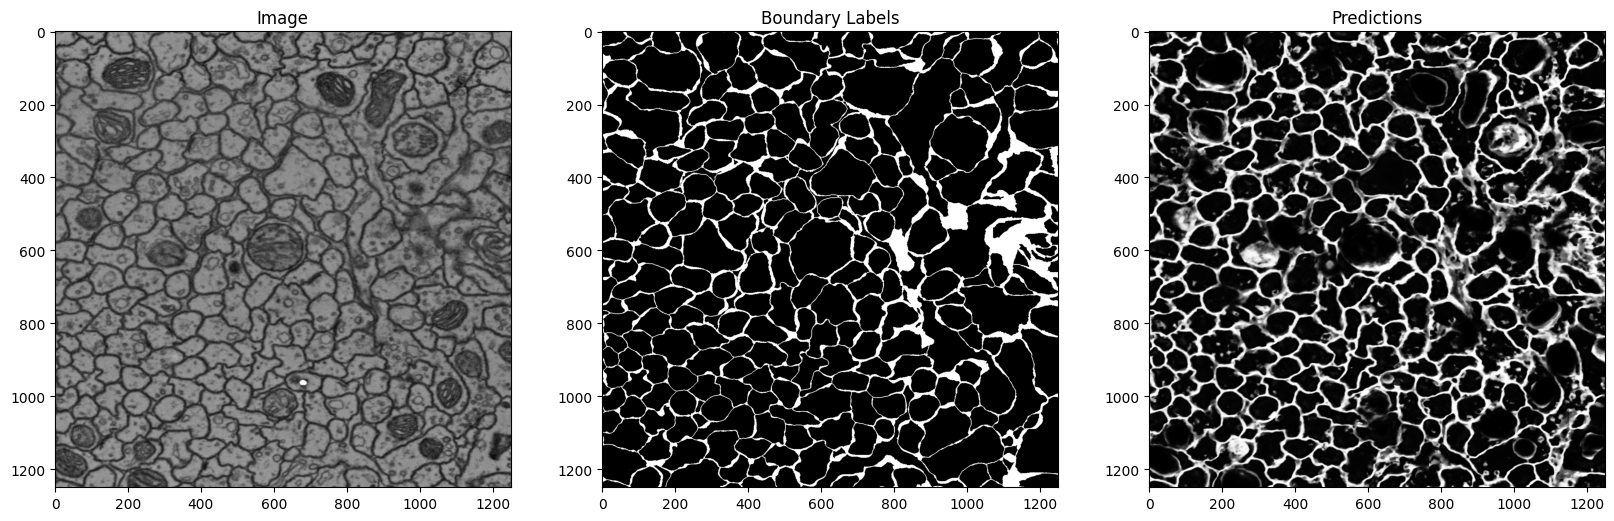

In [9]:
volume_paths = get_cremi_paths(path=data_path)

for volume_path in volume_paths:
    with h5py.File(volume_path, "r") as f:
        raw = f["volumes/raw"][:]
        labels = f["volumes/labels/neuron_ids"][:]

    raw, labels = raw[100:], labels[100:]  # Perform test on the last 25 slices.
    labels = find_boundaries(labels)  # Get the boundaries from instances.
    # The test volume and the corresponding labels are of shape (25, 1250, 1250).

    # Q. How can I run the predictions over the entire image / volume?
    # Thought 1: Can we pass entire input volume to the model to generate predictions?
    # Answer 1: It is not possible to provide inputs which are not divisible by (16, 16, 16) (for 3d inputs)

    # Example 1: Run prediction on entire volume, returns an error stating the aforementioned points.
    # raw = torch.from_numpy(raw)[None, None].to(torch.float32)
    # prediction = model(raw.to(device))

    # Thought 2: Can we provide a crop matching the desired shape / patch shape for training?
    # Answer 2: Yes. This would work for the provided crop. You would need to perform it over all the crops to get your desired result.

    # Example 2: Run predictions for the desired crop of shape (16, 512, 512)
    # raw, labels = raw[:16, :512, :512], labels[:16, :512, :512]
    # raw = torch.from_numpy(raw)[None, None].to(torch.float32)
    # prediction = model(raw.to(device))

    # Thought 3: I have predictions for each crops. Can I stitch them back as an entire prediction volume?
    # Answer 3: You can stitch the crops manually, however this has a major downside:
    # recovering the objects at the intersection of two crops is difficult (might lead to artifacts / strange predictions)
    # Hence, we need to take care of objects at the intersection of two crops.
    # Thanks to 'torch-em' and'elf', this is taken care of using "tiling window-based prediction".
    # The core idea is to generate predictions over a tile (crop) of shape (z1, y1, x1),
    # and another step generates predictions over a halo (overlap crop) of shape (z2, y2, x2) over all tile edges,
    # i.e. recovering objects at the tile intersections.
    # The recommended choice for tile and halo shape is that the training patch shape should match (z1+2*(z2/2), y1+2*(y2/2), x1+2*(x2/2))

    # Example 3: Run tiling window-based predictions.
    prediction = predict_with_halo(
        input_=raw,
        model=model,
        gpu_ids=[device],
        block_shape=(8, 384, 384),
        halo=(4, 128, 128),
        disable_tqdm=True,
    )
    prediction = prediction.squeeze()

    fig, ax = plt.subplots(1, 3, figsize=(20, 20))

    ax[0].imshow(raw[0], cmap="gray")
    ax[0].set_title("Image")

    ax[1].imshow(labels[0], cmap="gray")
    ax[1].set_title("Boundary Labels")

    ax[2].imshow(prediction[0], cmap="gray")
    ax[2].set_title("Predictions")

    plt.show()

    break  # comment this out if you would like to run this across all test volumes.

_This notebook was last ran on November 12, 2024_